In [1]:
"""
生成图片 使其学习之后 输出错误的 标签
"""

'\n生成图片 使其学习之后 输出错误的 标签\n'

In [2]:
import os
import pandas as pd 
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F 
import torchvision.datasets as datasets
from torch.utils.data import Dataset,DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available()else "cpu"


In [3]:
#read data
#读取数据集
class Adverdataset(Dataset):
    def __init__(self,root,label,transforms):
        self.root = root
        self.label  =torch.from_numpy(label).long()
        self.transforms = transforms
        self.fnames = []

        for i in range(200):
            self.fnames.append("{:03d}".format(i))
    
    def __getitem__(self,idx):
        img = Image.open(os.path.join(self.root,self.fnames[idx]+'.png'))
        img = self.transforms(img)
        label  = self.label[idx]
        return img,label
    
    def __len__(self):
        #200张图片
        return 200


In [4]:
#Attacker
device = "cuda" if torch.cuda.is_available() else "cpu"
class Attacker:
    def __init__(self,img_dir,label):
        #读入预训练模型
        self.model = models.vgg16(pretrained=True)
        self.model.to(device)
        self.model.eval()
        self.mean = [0.485,0.456,0.406]
        self.std = [0.229,0.224,0.225]
        self.normalize = transforms.Normalize(self.mean, self.std, inplace=False)
        transform = transforms.Compose([
            transforms.Resize((224,224),interpolation=3),
            transforms.ToTensor(),
            self.normalize
        ])
        self.datasets  = Adverdataset('./data/images',label,transform)
        self.loader  =torch.utils.data.DataLoader(self.datasets,batch_size=1,shuffle=False)

    #FGSM攻击
    def fgsm_attack(self,image,epsilon,data_grad):
        #find the dirction of gradient
        sign_data_grad  = data_grad.sign()
        perturbed_image = image+epsilon*sign_data_grad
        return perturbed_image

    def attack(self,epsilon):
        adv_examples = []
        wrong,fail,success = 0,0,0
        for(data,target) in self.loader:
            data,target = data.to(device),target.to(device)
            data_raw = data 
            data.requires_grad = True
            output = self.model(data)
            init_pred = output.max(1,keepdim =True)[1]

            if init_pred.item() !=target.item():
                wrong+=1
                continue
            loss = F.nll_loss(output,target)
            self.model.zero_grad()
            loss.backward()
            data_grad = data.grad.data 
            perturbed_data = self.fgsm_attack(data, epsilon, data_grad)

            output = self.model(perturbed_data)
            final_pred = output.max(1,keepdim= True)[1]
            
            if final_pred.item() == target.item():
                fail+=1
            #将攻击成功的存入
            else:
                success+=1
                if len(adv_examples)<5:
                    adv_ex = perturbed_data*torch.tensor(self.std,device =device).view(3,1,1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
                    adv_ex = adv_ex.squeeze().detach().cpu().numpy()
                    data_raw = data_raw *torch.tensor(self.std,device =device).view(3,1,1) +torch.tensor(self.mean,device = device).view(3, 1, 1)
                    data_raw = data_raw.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), data_raw , adv_ex))
        
        final_acc = (fail / (wrong + success + fail))
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, fail, len(self.loader), final_acc))
        return adv_examples, final_acc   

In [5]:
#执行攻击 并显示攻击成功率
if __name__ =='__main__':
    df = pd.read_csv('./data/labels.csv')
    df = df.loc[:,'TrueLabel'].to_numpy()
    label_name = pd.read_csv('./data/categories.csv')
    label_name = label_name.loc[:,'CategoryName'].to_numpy()
    #
    attacker = Attacker('./data/images',df)
    epsilons = [0.1,0.01]
    accuracies,examples = [],[]
    for eps in epsilons:
        ex,acc = attacker.attack(eps)
        accuracies.append(acc)
        examples.append(ex)

Epsilon: 0.1	Test Accuracy = 6 / 200 = 0.03

Epsilon: 0.01	Test Accuracy = 54 / 200 = 0.27



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


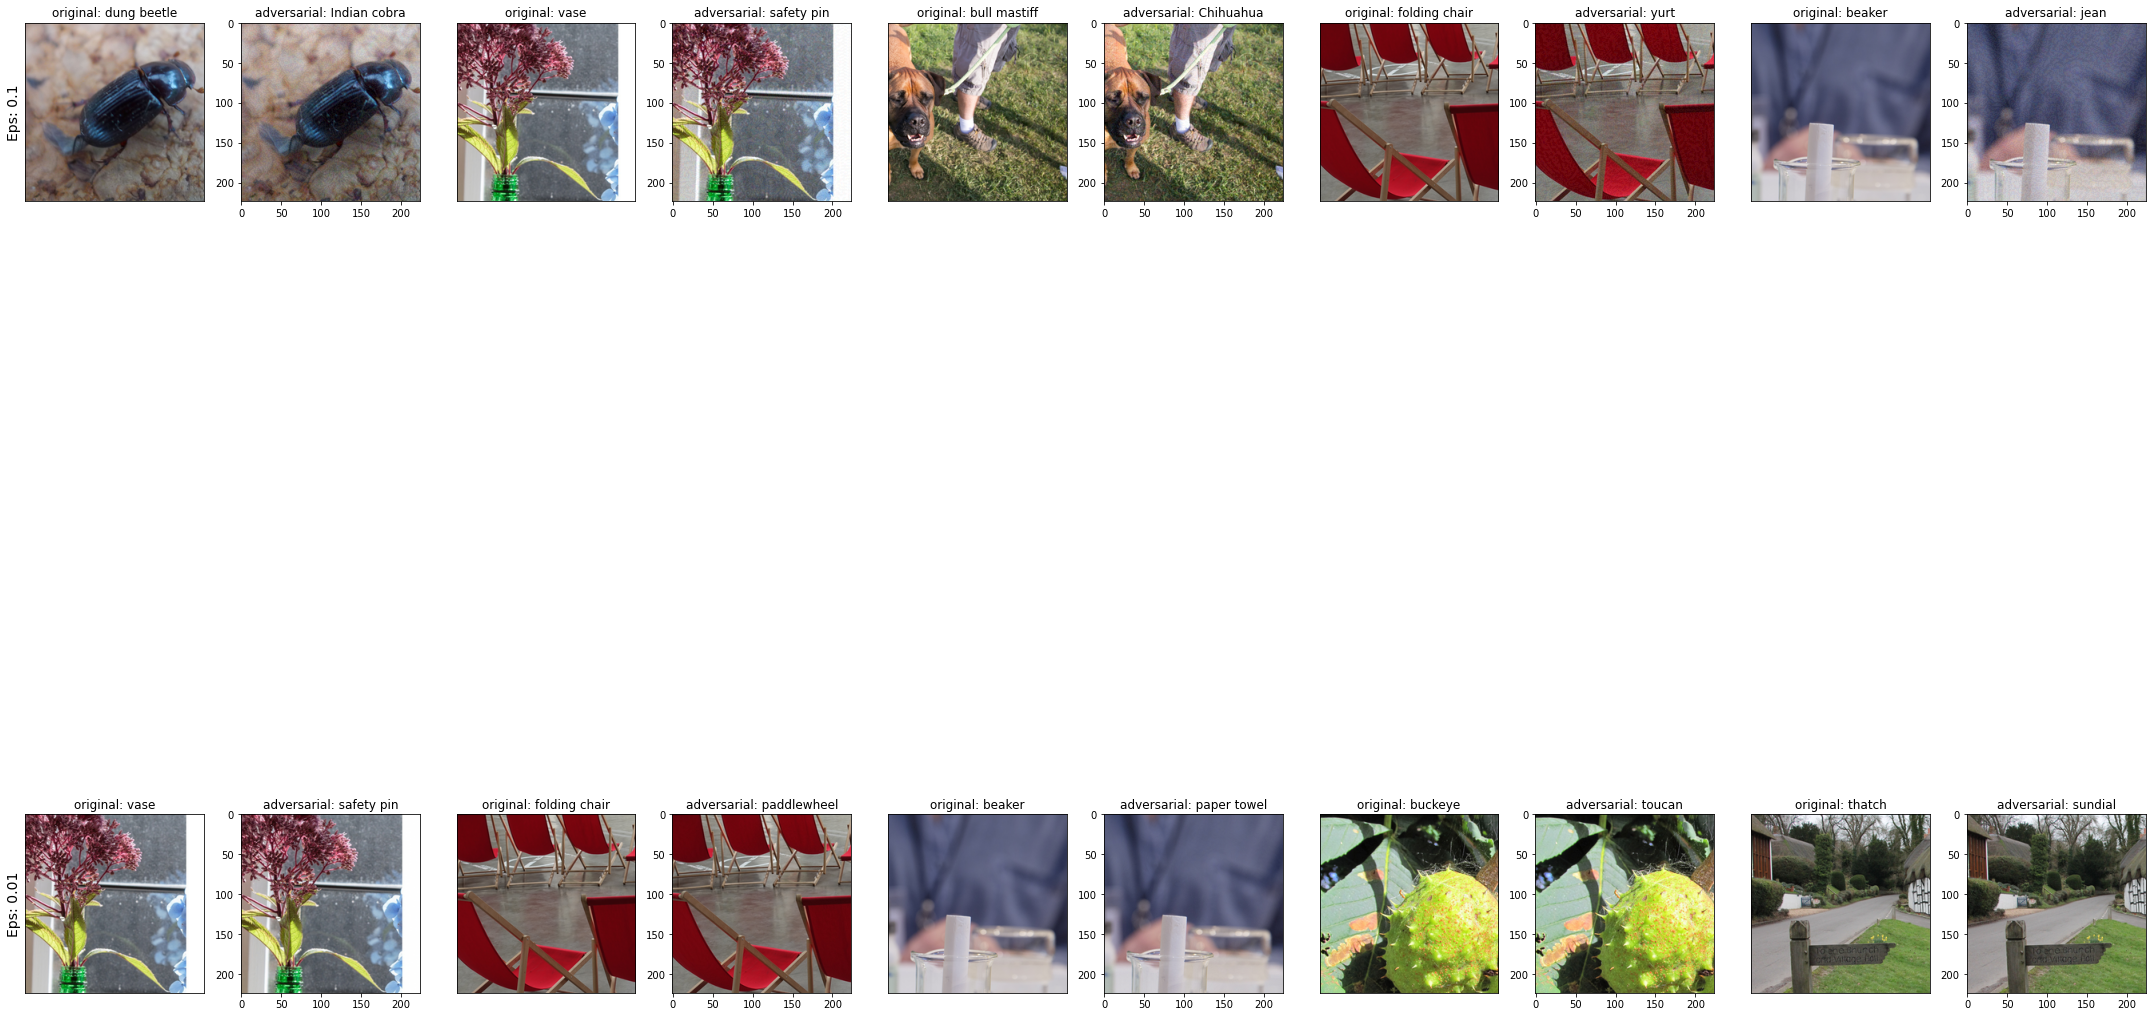

In [6]:
cnt = 0
plt.figure(figsize = (30,30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,orig_img, ex = examples[i][j]
        # plt.title("{} -> {}".format(orig, adv))
        plt.title("original: {}".format(label_name[orig].split(',')[0]))
        orig_img = np.transpose(orig_img, (1, 2, 0))
        plt.imshow(orig_img)
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(label_name[adv].split(',')[0]))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()